<a href="https://colab.research.google.com/github/jaikishan2020/DAT8/blob/master/Regression_mpg_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import seaborn

In [110]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [111]:
import pathlib

In [112]:
from __future__ import absolute_import,division,print_function

In [113]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

In [114]:
col_names=['mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin']

In [115]:
raw_data_set=pd.read_csv(url,names=col_names,comment='\t',sep=' ',skipinitialspace=True)

In [116]:
raw_data_set.shape

(398, 8)

In [117]:
raw_data_set.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [118]:
dataset=raw_data_set.copy()
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
393,27.0,4,140.0,86.00,2790.0,15.6,82,1
394,44.0,4,97.0,52.00,2130.0,24.6,82,2
395,32.0,4,135.0,84.00,2295.0,11.6,82,1
396,28.0,4,120.0,79.00,2625.0,18.6,82,1
397,31.0,4,119.0,82.00,2720.0,19.4,82,1


In [119]:
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

In [120]:
dataset['origin'].value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

In [121]:
dataset['USA']=(dataset['origin']==1)*1.0

In [122]:
dataset['USA'].value_counts()

1.0    249
0.0    149
Name: USA, dtype: int64

In [123]:
dataset['Europe']=(dataset['origin']==2)*1.0
dataset['Japan']=(dataset['origin']==3)*1.0

In [124]:
dataset['Europe'].value_counts()

0.0    328
1.0     70
Name: Europe, dtype: int64

In [125]:
dataset['Japan'].value_counts()

0.0    319
1.0     79
Name: Japan, dtype: int64

In [126]:
dataset.pop('origin')

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: origin, Length: 398, dtype: int64

In [127]:
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


In [128]:
dataset[dataset['horsepower']=='?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,Europe,Japan
32,25.0,4,98.0,?,2046.0,19.0,71,1.0,0.0,0.0
126,21.0,6,200.0,?,2875.0,17.0,74,1.0,0.0,0.0
330,40.9,4,85.0,?,1835.0,17.3,80,0.0,1.0,0.0
336,23.6,4,140.0,?,2905.0,14.3,80,1.0,0.0,0.0
354,34.5,4,100.0,?,2320.0,15.8,81,0.0,1.0,0.0
374,23.0,4,151.0,?,3035.0,20.5,82,1.0,0.0,0.0


In [129]:
i=dataset[dataset['horsepower']=='?'].index

In [130]:
print(i)

Int64Index([32, 126, 330, 336, 354, 374], dtype='int64')


In [131]:
dataset.drop(i,inplace=True)

In [132]:
dataset['horsepower']=dataset['horsepower'].astype('float64')

In [133]:
dataset.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
USA             float64
Europe          float64
Japan           float64
dtype: object

In [134]:
train_dataset=dataset.sample(frac=0.8,random_state=0)
test_dataset=dataset.drop(train_dataset.index)

In [135]:
train_dataset.shape

(314, 10)

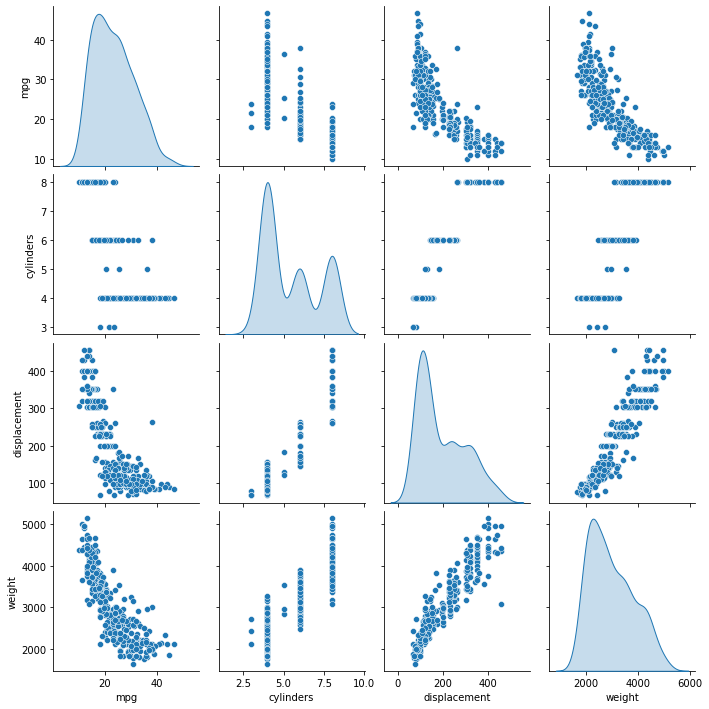

In [136]:
sns.pairplot(train_dataset[['mpg','cylinders','displacement','weight']],diag_kind='kde')

In [137]:
train_stats=train_dataset.describe()
train_stats.pop('mpg')
train_stats=train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
model_year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [138]:
train_labels=train_dataset.pop('mpg')
test_labels=test_dataset.pop('mpg')

In [139]:
def norm(x):
  return((x-train_stats['mean'])/train_stats['std'])

In [140]:
normed_train_data=norm(train_dataset)
normed_test_data=norm(test_dataset)

In [141]:
def build_model():
  model=keras.Sequential([
                          layers.Dense(64,activation=tf.nn.relu,input_shape=[len(train_dataset.keys())]),
                          layers.Dense(64,activation=tf.nn.relu),
                          layers.Dense(1)
  ])
  optimizer=tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',optimizer=optimizer,metrics=['mae','mse'])
  return model

In [142]:
len(train_dataset.keys())

9

In [143]:
reg_model=build_model()

In [144]:
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [145]:
normed_train_data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852


In [146]:
example_batch=normed_train_data[:10]
example_result=reg_model.predict(example_batch)
example_result

array([[-0.13922124],
       [-0.08968981],
       [ 0.8948386 ],
       [-0.09716228],
       [-0.08783013],
       [ 0.04449748],
       [-0.1098766 ],
       [ 0.28503335],
       [-0.02314387],
       [-0.30557817]], dtype=float32)

In [147]:
#Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100==0: print('.')
    print('.',end='')


In [148]:
EPOCHS=1000

In [149]:
history=reg_model.fit(
    normed_train_data,train_labels,
    epochs=EPOCHS,
    validation_split=0.2,verbose=0,
    callbacks=[PrintDot()]
)

.
.....................................................................................................
.....................................................................................................
.....................................................................................................
.....................................................................................................
.....................................................................................................
.....................................................................................................
.....................................................................................................
.....................................................................................................
.....................................................................................................
................................................................................

In [153]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [151]:
print(zip(history.history,history.epoch))

In [152]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.131140,0.912889,2.131140,10.817005,2.455616,10.817005,995
996,2.010470,0.915063,2.010470,10.411841,2.461595,10.411841,996
997,2.089603,0.922120,2.089603,9.996053,2.446699,9.996053,997
998,2.236909,0.990554,2.236909,10.543008,2.566509,10.543008,998
999,2.170346,0.970379,2.170346,10.496503,2.519304,10.496503,999


In [154]:
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,559.369629,22.201313,559.369629,545.455383,21.784815,545.455383,0
1,502.199097,20.844421,502.199097,486.749084,20.343636,486.749084,1
2,447.030762,19.460135,447.030762,425.836243,18.753378,425.836243,2
3,389.725952,17.913385,389.725952,362.981201,17.032217,362.981201,3
4,331.098541,16.279263,331.098541,299.046326,15.232779,299.046326,4


In [155]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean abs error [MPG')
  plt.plot(hist['epoch'],hist['mae'],label='Train error')
  plt.plot(hist['epoch'],hist['val_mae'],label='Val error')
  plt.legend()
  plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean squared error [MPG')
  plt.plot(hist['epoch'],hist['mse'],label='Train error')
  plt.plot(hist['epoch'],hist['val_mse'],label='Val error')
  plt.legend()
  plt.ylim([0,20])



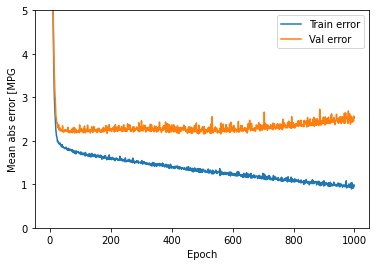

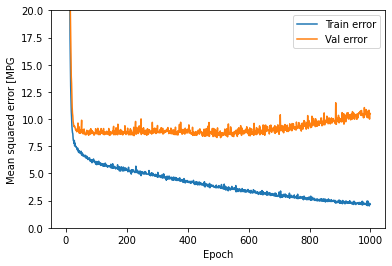

In [156]:
plot_history(history)

In [160]:
reg_model=build_model()
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history2=reg_model.fit(normed_train_data,train_labels,epochs=EPOCHS,validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])

.
................................................

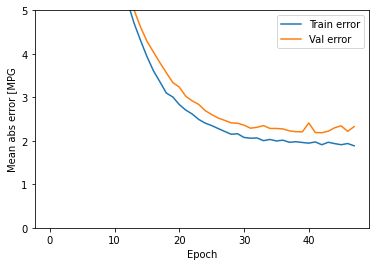

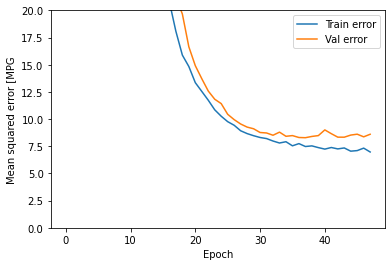

In [161]:
plot_history(history2)

In [162]:
loss,mae,mse=reg_model.evaluate(normed_test_data,test_labels,verbose=0)
print('Testing set Mean abs error :{:5.2f} MPG'.format(mae))

Testing set Mean abs error : 1.80 MPG


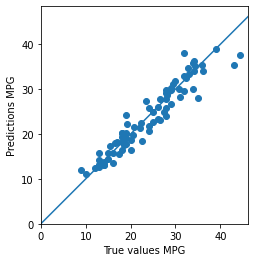

In [169]:
test_predictions=reg_model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_predictions)
plt.xlabel('True values MPG')
plt.ylabel('Predictions MPG')
plt.axis('equal')
plt.axis('square')
plt.xlim(0,plt.xlim()[1])
plt.ylim(0,plt.ylim()[1])
_=plt.plot([0,100],[0,100])



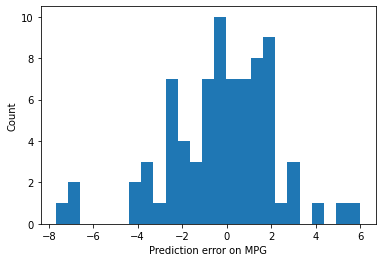

In [170]:
error=test_predictions-test_labels
plt.hist(error,bins=25)
plt.xlabel('Prediction error on MPG')
_=plt.ylabel('Count')